In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
print(os.getcwd())
import time
import gc
import torch
import bisect

#import empirical cdf
# import sys
# sys.path.append(os.path.abspath('../../src'))

from data_processing import gen_ckpt_steps, move_dict_to_device, get_other_err, get_mop_ratios_ckpt, compute_ratio
# sys.path.append(os.path.abspath('..'))

from conv_plots_funcs import train_conv_plots

from check_ecdf import get_empirical_cdf

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

/home/sultand/TFs_do_KF_ICL/src
/home/sultand/TFs_do_KF_ICL/src
Using device: cuda
Using device: cuda


## experiment details

In [17]:
trainA = "upperTriA" #"unifA" #"gaussA" #"gaussA_noscale" #"rotDiagA" #"rotDiagA_unif" #"rotDiagA_gauss" #"upperTriA" #"single_system" #"cond_num" #"mix_gauss_upptri_rotdiag"
valA = "upperTriA" #"unifA" #"gaussA" #"gaussA_noscale" #"rotDiagA" #"rotDiagA_unif" #"rotDiagA_gauss" #"upperTriA" #"single_system" #"cond_num"
num_val_systems = 1000
context_len = 250
nx = 20
print("nx:", nx)

print('context_len:', context_len)
print('trainA:', trainA)
print('valA:', valA)
print("num_val_systems:", num_val_systems)
C_dist = "_gauss_C" #"_unif_C" #"_gauss_C" #"_gauss_C_large_var" #"_single_system"
main_ckpt_step = 192000

experiments = ["241121_182725.0ad317_upperTriA_state_dim_3_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241124_004016.7a9db9_upperTriA_state_dim_20_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241124_025241.7a9db9_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_40000", "241203_014212.9ee182_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_120000", "241103_013426.749aca_gaussA_gauss_C_lr_0", "241203_014142.301b1c_gaussA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_120000"]

# experiments = ["241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241121_182725.0ad317_upperTriA_state_dim_3_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241124_004016.7a9db9_upperTriA_state_dim_20_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000", "241124_025241.7a9db9_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_40000"]#, "241107_233959.102bf2_gaussA_gauss_C_mix_lr_0"]#, "241117_204226.922f5f_rotDiagA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000"]
print("experiment strings:", experiments)

nx: 20
context_len: 250
trainA: upperTriA
valA: upperTriA
num_val_systems: 1000
experiment strings: ['241121_182725.0ad317_upperTriA_state_dim_3_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000', '241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000', '241124_004016.7a9db9_upperTriA_state_dim_20_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000', '241124_025241.7a9db9_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_40000', '241203_014212.9ee182_upperTriA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_120000', '241103_013426.749aca_gaussA_gauss_C_lr_0', '241203_014142.301b1c_gaussA_state_dim_20_gauss_C_state_dim_mix_lr_1.584893192461114e-05_num_train_sys_120000']


## Load predictions and Compute Ratios

In [ ]:
# def gen_ckpt_steps(minval, maxval, interval):
#     ckpt_steps = list(range(minval, maxval + 1, interval))
#     print("ckpt_steps:", ckpt_steps)
#     return ckpt_steps

# def move_dict_to_device(d, device):
#     for key, value in d.items():
#             d[key] = torch.Tensor(value).to(device)
#     return d

# def get_other_err(valA, C_dist, ckpt_step, exper, curve, nx=nx):
#     path = f"../outputs/GPT2/{exper}/prediction_errors{C_dist}_step={str(ckpt_step)}.ckpt/{valA}_state_dim_{nx}_err_lss.pkl"
#     curve_err = None

#     if os.path.exists(path):
#         print(os.path.abspath(path))
#         with open(path, 'rb') as f:
#             err_lss = pickle.load(f)
#             err_lss = move_dict_to_device(err_lss, device)
#         if curve in err_lss:
#             curve_err = err_lss[curve]
#             print(f"loaded {curve} error")
#         else:
#             raise ValueError(f"{curve} Preds not in this checkpoint")
#         del err_lss
#         torch.cuda.empty_cache()
#         gc.collect()
#     else:
#         raise ValueError("Preds do not exist for this checkpoint")
#     return curve_err

# def get_mop_ratios_ckpt(valA, C_dist, ckpt_step, exper, nx=nx):
#     mop_err = None
#     pred_ckpt = None
#     #print the absolute path of the experiment

#     path = f"../outputs/GPT2/{exper}/prediction_errors{C_dist}_step={str(ckpt_step)}.ckpt/{valA}_state_dim_{nx}_err_lss.pkl"
#     if os.path.exists(path):
#         print(os.path.abspath(path))
#         #load prediction errors

#         with open(path, 'rb') as f:
#             err_lss = pickle.load(f)
#             err_lss = move_dict_to_device(err_lss, device)

#         mop_err = err_lss["MOP"]
#         pred_ckpt = ckpt_step
        
#         del err_lss
#         torch.cuda.empty_cache()
#         gc.collect()

#         if not (mop_err == None):
#             print("Loaded Transformer Errors")
#         else:
#             raise ValueError("TF Preds do not exist for this checkpoint")
#     else:
#         print(f"path does not exist: {path}")
#     return mop_err, pred_ckpt

# def compute_ratio(ind, err, kalman_err):
    
#     if err.shape != kalman_err.shape:
#         #take the reciprocal of every element in kalman_err
#         rec_kalman = 1/kalman_err
#         #multiply rec_kalman by analytical error
#         irr_err = err[:,0]
#         ratios = rec_kalman * irr_err[:,np.newaxis, np.newaxis]
#     else:
#         ratios = err/kalman_err[:,:,0:err.shape[-1]]

#     # Compute the 25th, 50th, and 75th percentiles along axis 1
#     device = ratios.device
#     percentiles = torch.tensor([0.25, 0.5, 0.75], device=device)

#     #take the median of the ratios along axis 1
#     ratios, _ = torch.median(ratios, axis=1)

#     if ind == None:
#         ratios_percentiles = torch.quantile(ratios, percentiles, dim=0)
#         # ratios_med = torch.median(ratios, axis=0)
#     else:
#         ratios_percentiles = torch.quantile(ratios[:,ind], percentiles)
#         # ratios_med = torch.median(ratios[:, ind])

#     del ratios
#     torch.cuda.empty_cache()
#     gc.collect()
    
#     return ratios_percentiles

make the below training convergence plots into a function that takes experiments and kal_ckpt_steps and outputs figures, and the data that is plotted on the figures. Think about saving the plot data to file

In [ ]:
def train_conv_plots(experiments, trainAs, kal_ckpt, valA, num_val_systems, compute_more_ckpts=False, ind=250, min_ckpt=79, max_ckpt=79000, interval=79):
    num_preds = 3 #len(experiments) #number of predictors to plot
    colors = plt.cm.tab10(np.linspace(0, 1, num_preds))

    plot_time = time.ctime()

    #create a figure with subplots for each of the m indexes for the cdfs
    fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)
    filename = f'training_dist_comparison_val_{valA}_state_dim_{nx}_val_sys_{num_val_systems}_{time.time()}.png'

    parent_path = "../outputs/GPT2/"

    filepath = os.path.abspath(f"../outputs/train_conv/{filename}")
    print(filepath)

    ckpt_steps = gen_ckpt_steps(min_ckpt, max_ckpt, interval)

    i = 0
    for experiment in experiments:
        if not os.path.exists(parent_path + experiment + "/train_conv/quantiles.npz") or compute_more_ckpts:
            pred_ckpts = []
            quantiles = []
            print("\n\ni", i)
            kal_err = get_other_err(valA, C_dist, kal_ckpt[i], experiment, "Kalman", nx=nx)
            for ckpt_step in ckpt_steps:
                mop_err, pred_ckpt = get_mop_ratios_ckpt(valA, C_dist, ckpt_step, experiment, nx=nx)
                if pred_ckpt:
                    pred_ckpts.append(pred_ckpt)
                    quantile = compute_ratio(ind=ind, err=mop_err, kalman_err=kal_err)
                    if isinstance(quantile, torch.Tensor):
                        quantile = quantile.cpu().numpy()
                    del mop_err
                    quantiles.append(quantile)

                    torch.cuda.empty_cache()
                    gc.collect()
            del kal_err
            torch.cuda.empty_cache()
            gc.collect()

            quantiles = np.array(quantiles)
            
            #save quantiles to file
            os.makedirs(parent_path + experiment + "/train_conv", exist_ok=True)
            np.savez_compressed(parent_path + experiment + "/train_conv/quantiles.npz", pred_ckpts=pred_ckpts, quantiles=quantiles)
        else:
            data = np.load(parent_path + experiment + "/train_conv/quantiles.npz", allow_pickle=False)
            pred_ckpts = data["pred_ckpts"]
            quantiles = data["quantiles"]

        quantiles -= 1
        print("quantiles shape", quantiles.shape)    
        ##plotting stuff
        ax.plot(pred_ckpts, quantiles[:,1], marker="*", linewidth=3, color= colors[i], label=trainAs[i] + " Median")# label= f"Experiment: {experiments[i]} Median")
        plt.fill_between(pred_ckpts, quantiles[:,0], quantiles[:,2], color=colors[i], alpha=0.2) #, label='25th-75th Percentile Range')
        torch.cuda.empty_cache()
        gc.collect()

        ax.set_title(f"Error Ratio of Median Test System vs Training Iteration: Gaussian Test Distribution.")
        ax.grid(True)
        ax.set_ylabel("Error of Median Test System / Emp Kal Error")
        ax.set_xlabel("Training Iteration")
        ax.minorticks_on()
        ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
        ax.legend()
        ax.set_yscale("log")
        ax.set_xscale("log")

        fig.text(0.5, 0.01, f'Generated at {plot_time}', ha='center')

        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        #save the figures
        fig.savefig(filepath)
        if i ==0:
            lr_med = quantiles[1,:]
            lr_pred_ckpts = pred_ckpts

        i+=1

    return lr_med, lr_pred_ckpts

/home/sultand/mop_modifications/streamlined_mop/outputs/train_conv/training_dist_comparison_val_gaussA_state_dim_10_val_sys_1000_1732749142.73662.png
ckpt_steps: [79, 158, 237, 316, 395, 474, 553, 632, 711, 790, 869, 948, 1027, 1106, 1185, 1264, 1343, 1422, 1501, 1580, 1659, 1738, 1817, 1896, 1975, 2054, 2133, 2212, 2291, 2370, 2449, 2528, 2607, 2686, 2765, 2844, 2923, 3002, 3081, 3160, 3239, 3318, 3397, 3476, 3555, 3634, 3713, 3792, 3871, 3950, 4029, 4108, 4187, 4266, 4345, 4424, 4503, 4582, 4661, 4740, 4819, 4898, 4977, 5056, 5135, 5214, 5293, 5372, 5451, 5530, 5609, 5688, 5767, 5846, 5925, 6004, 6083, 6162, 6241, 6320, 6399, 6478, 6557, 6636, 6715, 6794, 6873, 6952, 7031, 7110, 7189, 7268, 7347, 7426, 7505, 7584, 7663, 7742, 7821, 7900, 7979, 8058, 8137, 8216, 8295, 8374, 8453, 8532, 8611, 8690, 8769, 8848, 8927, 9006, 9085, 9164, 9243, 9322, 9401, 9480, 9559, 9638, 9717, 9796, 9875, 9954, 10033, 10112, 10191, 10270, 10349, 10428, 10507, 10586, 10665, 10744, 10823, 10902, 10981, 110

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

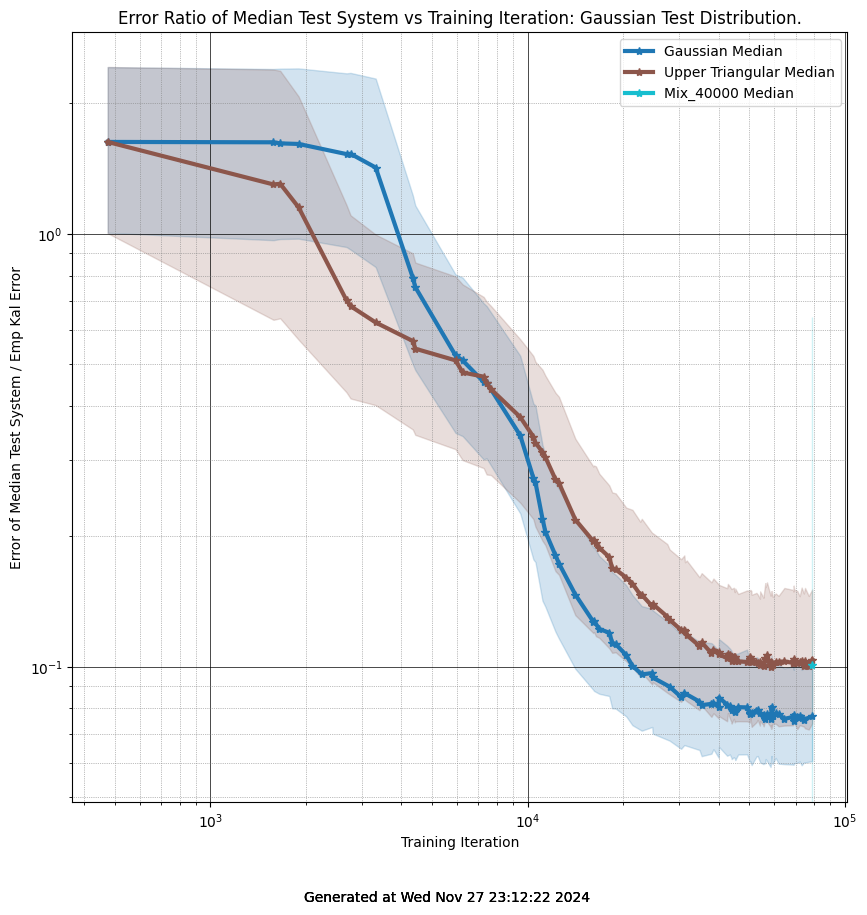

In [75]:
train_conv_plots(experiments, ["Gaussian", "Upper Triangular", "Mix_40000", "Mix_80000"], [79000, 79000, 79000, 157000], valA, num_val_systems)

## regression fit

In [85]:
#gradient descent

def power(x, a, b, c, d):
    if not isinstance(x, np.ndarray):
        x = np.array(x).astype(float)
    
    result = np.zeros_like(x, dtype=float)
    mask = (x - d) >= 0.0
    result[mask] = a * (x[mask] - d)**b + c
    
    return result

def e(x, a, b, c):
    if not isinstance(x, np.ndarray):
        x = np.array(x).astype(float)
    return a*np.exp(b*x) + c
    
def grad_pow(x, y, a, b, c, d):
    da, db, dc, dd = 0,0,0,0
    # print("x[0:10]", x[0:10])
    # print("x[0], a, b, c, d", x[0], a, b, c, d)
    # print("power of zero", (x[0] - d)**b)
    # print("power:", power(x[0], a,b,c,d))
    for i in range(len(y)):
        if power(x[i], a,b,c,d) == 0.0:
            continue
        else:
            da += (y[i] - power(x[i], a,b,c,d))*(-(x[i]-d)**b)
            db += (y[i] - power(x[i], a,b,c,d))*(-a*np.log(x[i]-d)*(x[i]-d)**b)
            dc += -(y[i] - power(x[i], a,b,c,d))
            dd += (y[i] - power(x[i], a,b,c,d))*(a*b*(x[i] - d)**(b-1))
    return np.array([da, db, dc,dd])

def grad_e(x, y, a, b, c):
    da, db, dc = 0,0,0
    # print("len(y)", len(y))
    # print("len(x)", len(x))
    for i in range(len(y)):
        exponent = np.clip(b*x[i], -50, 50)
        da += (y[i] - a*np.exp(exponent) - c)*(-np.exp(exponent))
        db += (y[i] - a*np.exp(exponent) - c)*(-a*x[i]*np.exp(exponent))
        # print("db", db)
        dc += -(y[i] - a*np.exp(exponent) - c)
    return np.array([da, db, dc])

def grad_descent_pow(x,y, init_coeff, lr, steps):
    coeff = init_coeff
    train_error = []
    for i in range(steps):
        err = 0.5*np.sum((y - power(x, coeff[0], coeff[1], coeff[2], coeff[3]))**2)
        train_error.append(err)
        if i % 100 == 0:
            print("step ", i)
            print("err:", err)
            print("coeff:", coeff)
        gradient = grad_pow(x,y, coeff[0], coeff[1], coeff[2], coeff[3])
        coeff[0] = coeff[0] - lr*gradient[0]
        # coeff[1] = coeff[1] - lr*gradient[1]
        coeff[2] = coeff[2] - lr*gradient[2]
        # coeff[3] = coeff[3] - lr*gradient[3]
        
    return coeff, train_error

def grad_descent_e(x,y, init_coeff, lr, steps):
    coeff = init_coeff
    train_error = []
    for i in range(steps):
        err = 0.5*np.sum((y - e(x, coeff[0], coeff[1], coeff[2]))**2)
        train_error.append(err)
        if i % 100 == 0:
            print("step ", i)
            print("err:", err)
            print("coeff:", coeff)
        gradient = grad_e(x,y, coeff[0], coeff[1], coeff[2])
        # print("grad_e", gradient)
        coeff[0] = coeff[0] - lr*gradient[0]
        coeff[1] = coeff[1] - lr*gradient[1]
        # coeff[2] = coeff[2] - lr*gradient[2]
        
    return coeff, train_error

step  0
err: 0.0018472910972967148
coeff: [30000.0, -1.4, 1.07, 5000.0]
step  100
err: 0.0013943828562046625
coeff: [np.float64(30000.000000055123), np.float64(-1.3913024238619622), np.float64(1.066653674124028), 5000.0]
step  200
err: 0.0013943828561682808
coeff: [np.float64(30000.000000076223), np.float64(-1.3913023494620136), np.float64(1.0666536434827714), 5000.0]
step  300
err: 0.0013943828561678454
coeff: [np.float64(30000.000000097323), np.float64(-1.391302349461519), np.float64(1.066653643482536), 5000.0]
step  400
err: 0.0013943828561673983
coeff: [np.float64(30000.000000118423), np.float64(-1.3913023494616013), np.float64(1.0666536434825382), 5000.0]
step  500
err: 0.0013943828561669602
coeff: [np.float64(30000.000000139524), np.float64(-1.3913023494616832), np.float64(1.0666536434825402), 5000.0]
step  600
err: 0.0013943828561665192
coeff: [np.float64(30000.000000160624), np.float64(-1.3913023494617651), np.float64(1.0666536434825424), 5000.0]
step  700
err: 0.00139438285616

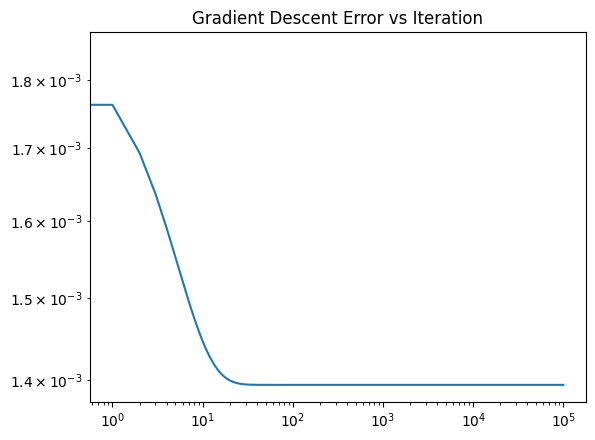

In [114]:
steps = int(1e5)
fincoeff, train_error = grad_descent_pow(lr_pred_ckpts[13:], lr_med[13:], [3e4, -1.4, 1.07, 5e3], 1e-2, steps) #-3e-4

plt.plot(list(range(steps)), train_error)
plt.title("Gradient Descent Error vs Iteration")
plt.yscale("log")
plt.xscale("log")
plt.show()

step  0
err: 0.5647861767825589
coeff: [2.2, -0.0003, 1.08]
step  100
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.4837514638552374e+46), 1.08]
step  200
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.5037603523970493e+46), 1.08]


/tmp/ipykernel_3685723/2720541213.py:11: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c


step  300
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.523769240938861e+46), 1.08]
step  400
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.543778129480673e+46), 1.08]
step  500
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.5637870180224847e+46), 1.08]
step  600
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.5837959065642965e+46), 1.08]
step  700
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.6038047951061083e+46), 1.08]
step  800
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.62381368364792e+46), 1.08]
step  900
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.643822572189732e+46), 1.08]
step  1000
err: 8.631149862156771
coeff: [np.float64(-4.494699257099148e+41), np.float64(-3.663831460731544e+46), 1.08]
step  1100
err: 8.631149862156771
coeff: [np.

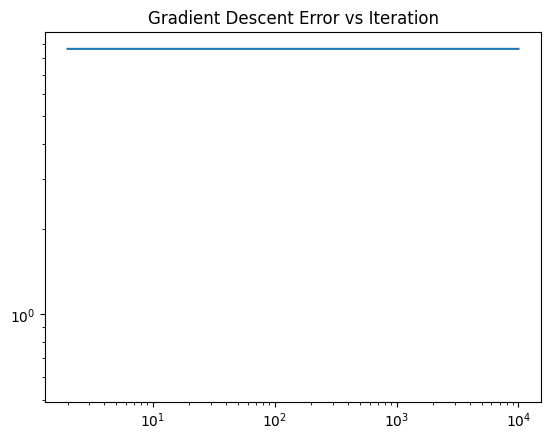

In [ ]:
steps = int(1e4)
fincoeff_e, train_error_e = grad_descent_e(pred_ckpts, medians, [2.2, -3e-4, 1.08], 1e-4, steps) 

plt.plot(list(range(steps)), train_error_e)
plt.title("Gradient Descent Error vs Iteration")
plt.yscale("log")
plt.xscale("log")
plt.show()

## plot

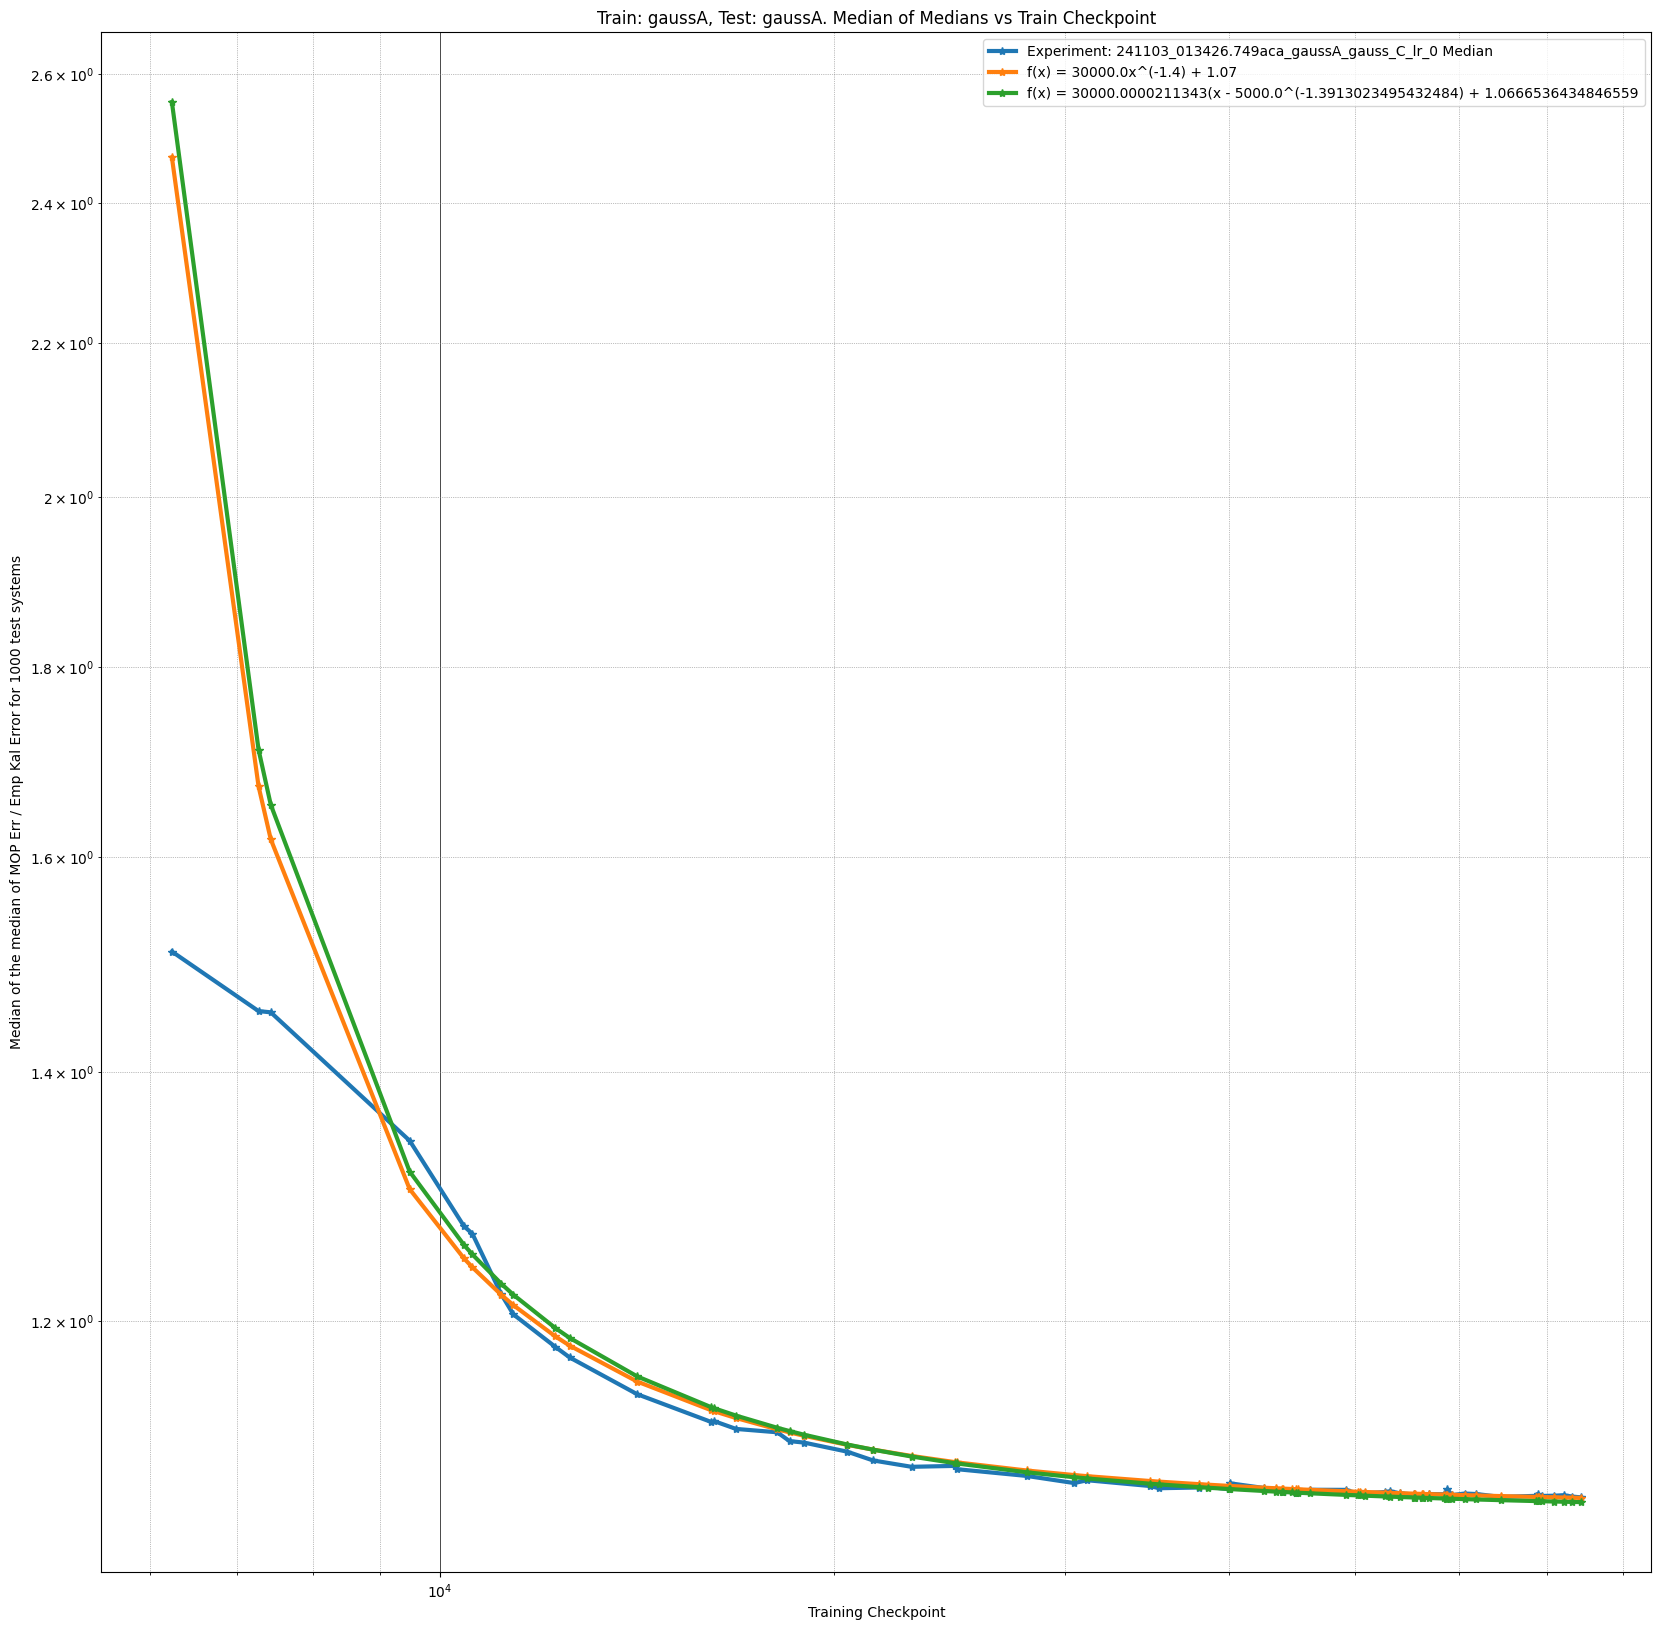

In [ ]:
#create a figure with subplots for each of the m indexes for the cdfs
fig2, ax2 = plt.subplots(1, 1, figsize=(20, 20), sharex=True)

ap, bp, cp, dp = 3e4, -1.4, 1.07, 5e3
ae, be, ce = 2.2, -3e-4, 1.08
ypow = power(lr_pred_ckpts, ap, bp, cp, dp)
ypowfit = power(lr_pred_ckpts, fincoeff[0], fincoeff[1], fincoeff[2], fincoeff[3])
yexp = e(lr_pred_ckpts, ae, be, ce)
# yexpfit = e(pred_ckpts, fincoeff_e[0], fincoeff_e[1], fincoeff_e[2])


##plotting stuff
ax2.plot(lr_pred_ckpts[10:], lr_med[10:], marker="*", linewidth=3, label=f"Experiment: {experiments[0]} Median")
ax2.plot(lr_pred_ckpts[10:], ypow[10:], marker="*", linewidth=3, label=f"f(x) = {ap}x^({bp}) + {cp}")
ax2.plot(lr_pred_ckpts[10:], ypowfit[10:], marker="*", linewidth=3, label=f"f(x) = {fincoeff[0]}(x - {fincoeff[3]}^({fincoeff[1]}) + {fincoeff[2]}")
# ax2.plot(lr_pred_ckpts, yexp, marker="*", linewidth=3, label=f"f(x) = {ae}e^({be}x) + {ce}")
# ax2.plot(pred_ckpts, yexpfit, marker="*", linewidth=3, label=f"f(x) = {fincoeff_e[0]}e^({fincoeff_e[1]}x) + {fincoeff_e[2]}")
torch.cuda.empty_cache()
gc.collect()

ax2.set_title(f"Train: {trainA}, Test: {valA}_state_dim_{nx}. Median of Medians vs Train Checkpoint")
ax2.grid(True)
ax2.set_ylabel("Median of the median of MOP Err / Emp Kal Error for 1000 test systems")
ax2.set_xlabel("Training Checkpoint")
ax2.minorticks_on()
ax2.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax2.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.legend()
plt.show()

## plots over entire context

In [18]:
def med_vs_cont(experiments, trainAs, kal_exper, kal_ckpt, mop_ckpts, valA, curves, num_val_systems, min_cutoff, context_len, nx, compute_quantiles=False):

    fig_med, ax_med = plt.subplots(1, 1, figsize=(10, 10), sharex=True)
    

    num_preds = len(experiments) + len(curves) #number of predictors to plot
    print(f"num_preds: {num_preds}")
    colors = plt.cm.tab10(np.linspace(0, 1, num_preds))

    torch.cuda.empty_cache()
    kal_err = get_other_err(valA, C_dist, kal_ckpt, experiments[kal_exper], curve="Kalman",nx=nx)

    parent_path = "../outputs/GPT2/"
    
    j = 0
    for experiment in experiments:
        print(f"j: {j}")
        if not os.path.exists(parent_path + experiment + f"/med_vs_cont/{valA}_quantiles_state_dim_{nx}.npz") or compute_quantiles:
            mop_err, pred_ckpt = get_mop_ratios_ckpt(valA, C_dist, mop_ckpts[j], experiment, nx=nx)
            if mop_err == None:
                print("transformer error now null")
            quantiles = compute_ratio(ind=None, err=mop_err, kalman_err=kal_err)
            if isinstance(quantiles, torch.Tensor):
                quantiles = quantiles.cpu().numpy()
            del mop_err
            torch.cuda.empty_cache()
            gc.collect()

            quantiles = np.array(quantiles)

            context = list(range(context_len+1))
            
            #save quantiles to file
            os.makedirs(parent_path + experiment + f"/med_vs_cont", exist_ok=True)
            np.savez_compressed(parent_path + experiment + f"/med_vs_cont/{valA}_quantiles_state_dim_{nx}.npz", context=context, quantiles=quantiles)
        else:
            data = np.load(parent_path + experiment + f"/med_vs_cont/{valA}_quantiles_state_dim_{nx}.npz", allow_pickle=False)
            context = data["context"]
            quantiles = data["quantiles"]
            
        
        quantiles -= 1

        ax_med.plot(context[min_cutoff:], quantiles[1][min_cutoff:], marker="*", linewidth=3, label= trainAs[j] + " Train", color=colors[j] if j < num_preds-len(curves) else colors[-1], zorder=num_preds - j)
        plt.fill_between(context[min_cutoff:], quantiles[0][min_cutoff:], quantiles[2][min_cutoff:], color=colors[j] if j < num_preds-len(curves) else colors[-1], alpha=0.15)
        del quantiles
        torch.cuda.empty_cache()
        j +=1

    
    i = 0
    color_ind = len(experiments)
    for curve in curves:
        if not os.path.exists(parent_path + experiments[kal_exper] + f"/med_vs_cont/{curve}_quantiles_state_dim_{nx}.npz") or compute_quantiles:
            err = get_other_err(valA, C_dist, kal_ckpt, experiments[kal_exper], curve=curves[i], nx=nx)
            quantiles = compute_ratio(ind=None, err=err, kalman_err=kal_err)
            if isinstance(quantiles, torch.Tensor):
                quantiles = quantiles.cpu().numpy()
            del err
            torch.cuda.empty_cache()
            gc.collect()
            context = list(range(251))

            #save quantiles to file
            os.makedirs(parent_path + experiments[kal_exper] + f"/med_vs_cont", exist_ok=True)
            np.savez_compressed(parent_path + experiments[kal_exper] + f"/med_vs_cont/{curve}_quantiles_state_dim_{nx}.npz", context=context, quantiles=quantiles)
        else:
            data = np.load(parent_path + experiments[kal_exper] + f"/med_vs_cont/{curve}_quantiles_state_dim_{nx}.npz", allow_pickle=False)
            context = data["context"]
            quantiles = data["quantiles"]

        
        quantiles -= 1

        ax_med.plot(context[min_cutoff:], quantiles[1][min_cutoff:], marker="*", linewidth=3, label=f"{curves[i]}", color=colors[i+color_ind], zorder=num_preds-(i+color_ind))
        plt.fill_between(context[min_cutoff:], quantiles[0][min_cutoff:], quantiles[2][min_cutoff:], color=colors[i+color_ind], alpha=0.15)
        i+=1

    # ax_med.set_title(f"Experiment: {experiment}. Checkpoint: {str(mop_ckpt)}. Train: {trainA}, Test: {valA}_state_dim_{nx}. Median of Medians vs Context")

    if valA == "gaussA":
        test_dist_string = "Gaussian"
    elif valA == "upperTriA":
        test_dist_string = "Upper Triangular"

    ax_med.set_title(f"Error Ratio of Median Test System vs Test Context Length: {test_dist_string} State Dim {str(nx)} Test Distribution.")
    ax_med.grid(True)
    ax_med.set_ylabel("Error of Median Test System / Emp Kal Error")
    ax_med.set_xlabel("Context")
    ax_med.minorticks_on()
    ax_med.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    ax_med.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    ax_med.set_xscale("log")
    ax_med.set_yscale("log")
    ax_med.legend()

    fig_med.text(0.5, 0.01, f'Transformer trained for 1000 epochs. Error bars are 25-75th percentile test systems. Generated at {time.ctime()}', ha='center')
    # fig_med.text(0.5, 0.01, f'Error bars are 25-75th percentile. Generated at {time.ctime()}', ha='center')

    filename = f'median_vs_context_train_{trainA}_state_dims_val_{valA}_state_dim_{nx}_{time.time()}.png'

    filepath = os.path.abspath(f"../outputs/context_len/figures/{filename}")
    print(filepath)

    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    #save the figures
    fig_med.savefig(filepath)

    return

In [ ]:
if valA == "gaussA":
    trainAs = ["Gaussian 3 Dim", "Gaussian 10 Dim",  "Gaussian 20 Dim", "Gaussian Mix 3,10,20 Dim ~13,333 each", "Gaussian Mix 3,10,20 Dim 40k each", f"Upper Triangular {nx} Dim", "Upper Triangular Mix 3,10,20 Dim"]
elif valA == "upperTriA":
    trainAs=["Upper Triangular 3 Dim", "Upper Triangular 10 Dim", "Upper Triangular 20 Dim", "Upper Triangular Mix 3,10,20 Dim ~13,333 each", "Upper Triangular Mix 3,10,20 Dim 40k each", f"Gaussian {nx} Dim", "Gaussian Mix 3,10,20 Dim"]
    
med_vs_cont(experiments, trainAs=trainAs, kal_exper=1, kal_ckpt=79000, mop_ckpts= [79000, 79000, 79000, 79000, 235000, 79000, 235000], valA=valA, curves=["OLS_ir_1", "OLS_ir_2", "OLS_ir_3"], num_val_systems=1000, min_cutoff=3, context_len=context_len, nx=nx)

num_preds: 10
/home/sultand/TFs_do_KF_ICL/outputs/GPT2/241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=79000.ckpt/upperTriA_state_dim_20_err_lss.pkl


In [19]:
plt.show()

## Check Zero Predictor Scale

i: 0
/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241121_182725.0ad317_upperTriA_state_dim_3_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=79000.ckpt/upperTriA_state_dim_3_err_lss.pkl
loaded Zero error
zero_err shape torch.Size([1000, 2000, 251])
mean shape torch.Size([1000, 251])
i: 1
/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241117_204332.cee615_upperTriA_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=79000.ckpt/upperTriA_state_dim_10_err_lss.pkl
loaded Zero error
zero_err shape torch.Size([1000, 2000, 251])
mean shape torch.Size([1000, 251])
i: 2
/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241124_004016.7a9db9_upperTriA_state_dim_20_gauss_C_lr_1.584893192461114e-05_num_train_sys_40000/prediction_errors_gauss_C_step=79000.ckpt/upperTriA_state_dim_20_err_lss.pkl
loaded Zero error
zero_err shape torch.Size([1000, 2000, 251])
mean shape torch.Size([1000, 251])


Text(0, 0.5, 'Norm Square of Zero Predictor Avged over Traces, Median System')

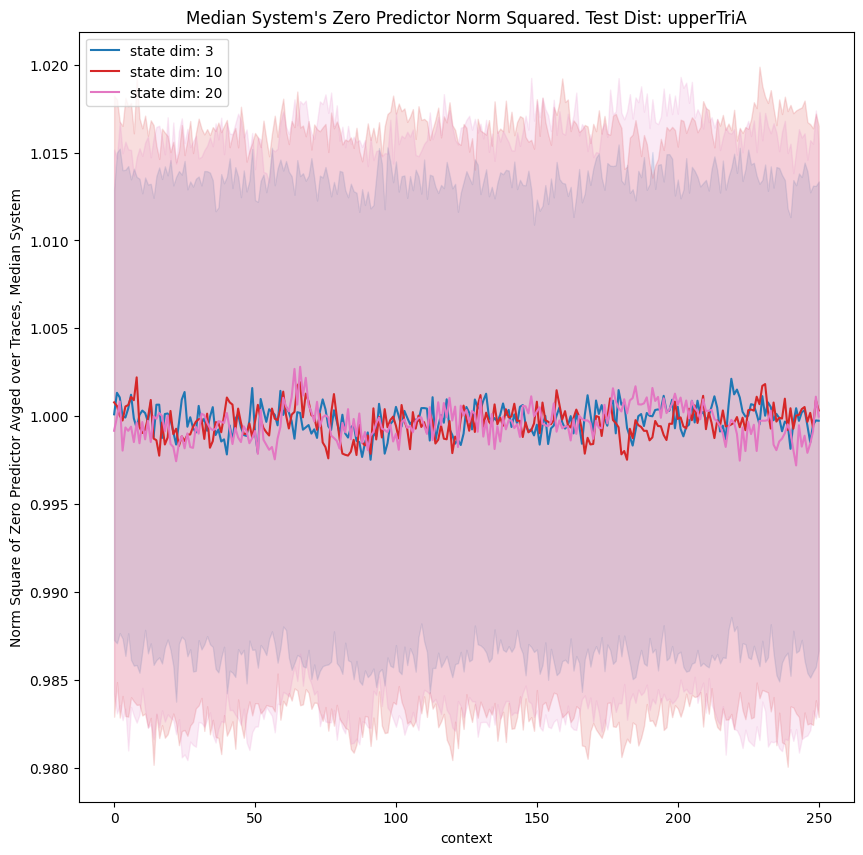

In [166]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)
state_dims = [3,10,20]
inds = [1,0,2]
colors = plt.cm.tab10(np.linspace(0, 1, len(experiments)))

percentiles = torch.tensor([0.25, 0.5, 0.75], device=device)

i = 0
for state_dim in state_dims:
    print("i:", i)
    zero_err = get_other_err(valA, C_dist, 79000, experiments[inds[i]], curve="Zero", nx=state_dim)
    print("zero_err shape", zero_err.shape)
    mean = torch.mean(zero_err, axis=1) #take average over traces
    print("mean shape", mean.shape)
    quantiles = torch.quantile(mean, percentiles, dim=0) #take quantiles over systems
    ax.plot(list(range(len(quantiles[1]))), quantiles[1], label=f"state dim: {state_dim}", color=colors[i])
    plt.fill_between(list(range(len(quantiles[1]))), quantiles[0], quantiles[2], color=colors[i], alpha=0.15)
    i+=1

ax.set_title(f"Median System's Zero Predictor Norm Squared. Test Dist: {valA}")
ax.legend()
ax.set_xlabel("context")
ax.set_ylabel("Norm Square of Zero Predictor Avged over Traces, Median System")
    

## Modulate of Num_tasks

In [42]:
experiments = ["241108_042909.a64358_gaussA_gauss_C_lr_1.584893192461114e-05_num_train_sys_10000", "241110_005027.2a2c58_gaussA_gauss_C_lr_1.584893192461114e-05_num_train_sys_20000", "241110_005223.7ef2c5_gaussA_gauss_C_lr_1.584893192461114e-05_num_train_sys_30000","241103_013426.749aca_gaussA_gauss_C_lr_0"]

/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241103_013426.749aca_gaussA_gauss_C_lr_0/prediction_errors_gauss_C_step=4424.ckpt/gaussA_err_lss.pkl
loaded Kalman error


i 0
/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241108_042909.a64358_gaussA_gauss_C_lr_1.584893192461114e-05_num_train_sys_10000/prediction_errors_gauss_C_step=20000.ckpt/gaussA_err_lss.pkl
type mop err and kal err <class 'torch.Tensor'> <class 'torch.Tensor'>


i 1
/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241110_005027.2a2c58_gaussA_gauss_C_lr_1.584893192461114e-05_num_train_sys_20000/prediction_errors_gauss_C_step=40000.ckpt/gaussA_err_lss.pkl
type mop err and kal err <class 'torch.Tensor'> <class 'torch.Tensor'>


i 2
/home/sultand/mop_modifications/streamlined_mop/outputs/GPT2/241110_005223.7ef2c5_gaussA_gauss_C_lr_1.584893192461114e-05_num_train_sys_30000/prediction_errors_gauss_C_step=59000.ckpt/gaussA_err_lss.pkl
type mop err and kal err <class 'torch.Tensor'> <

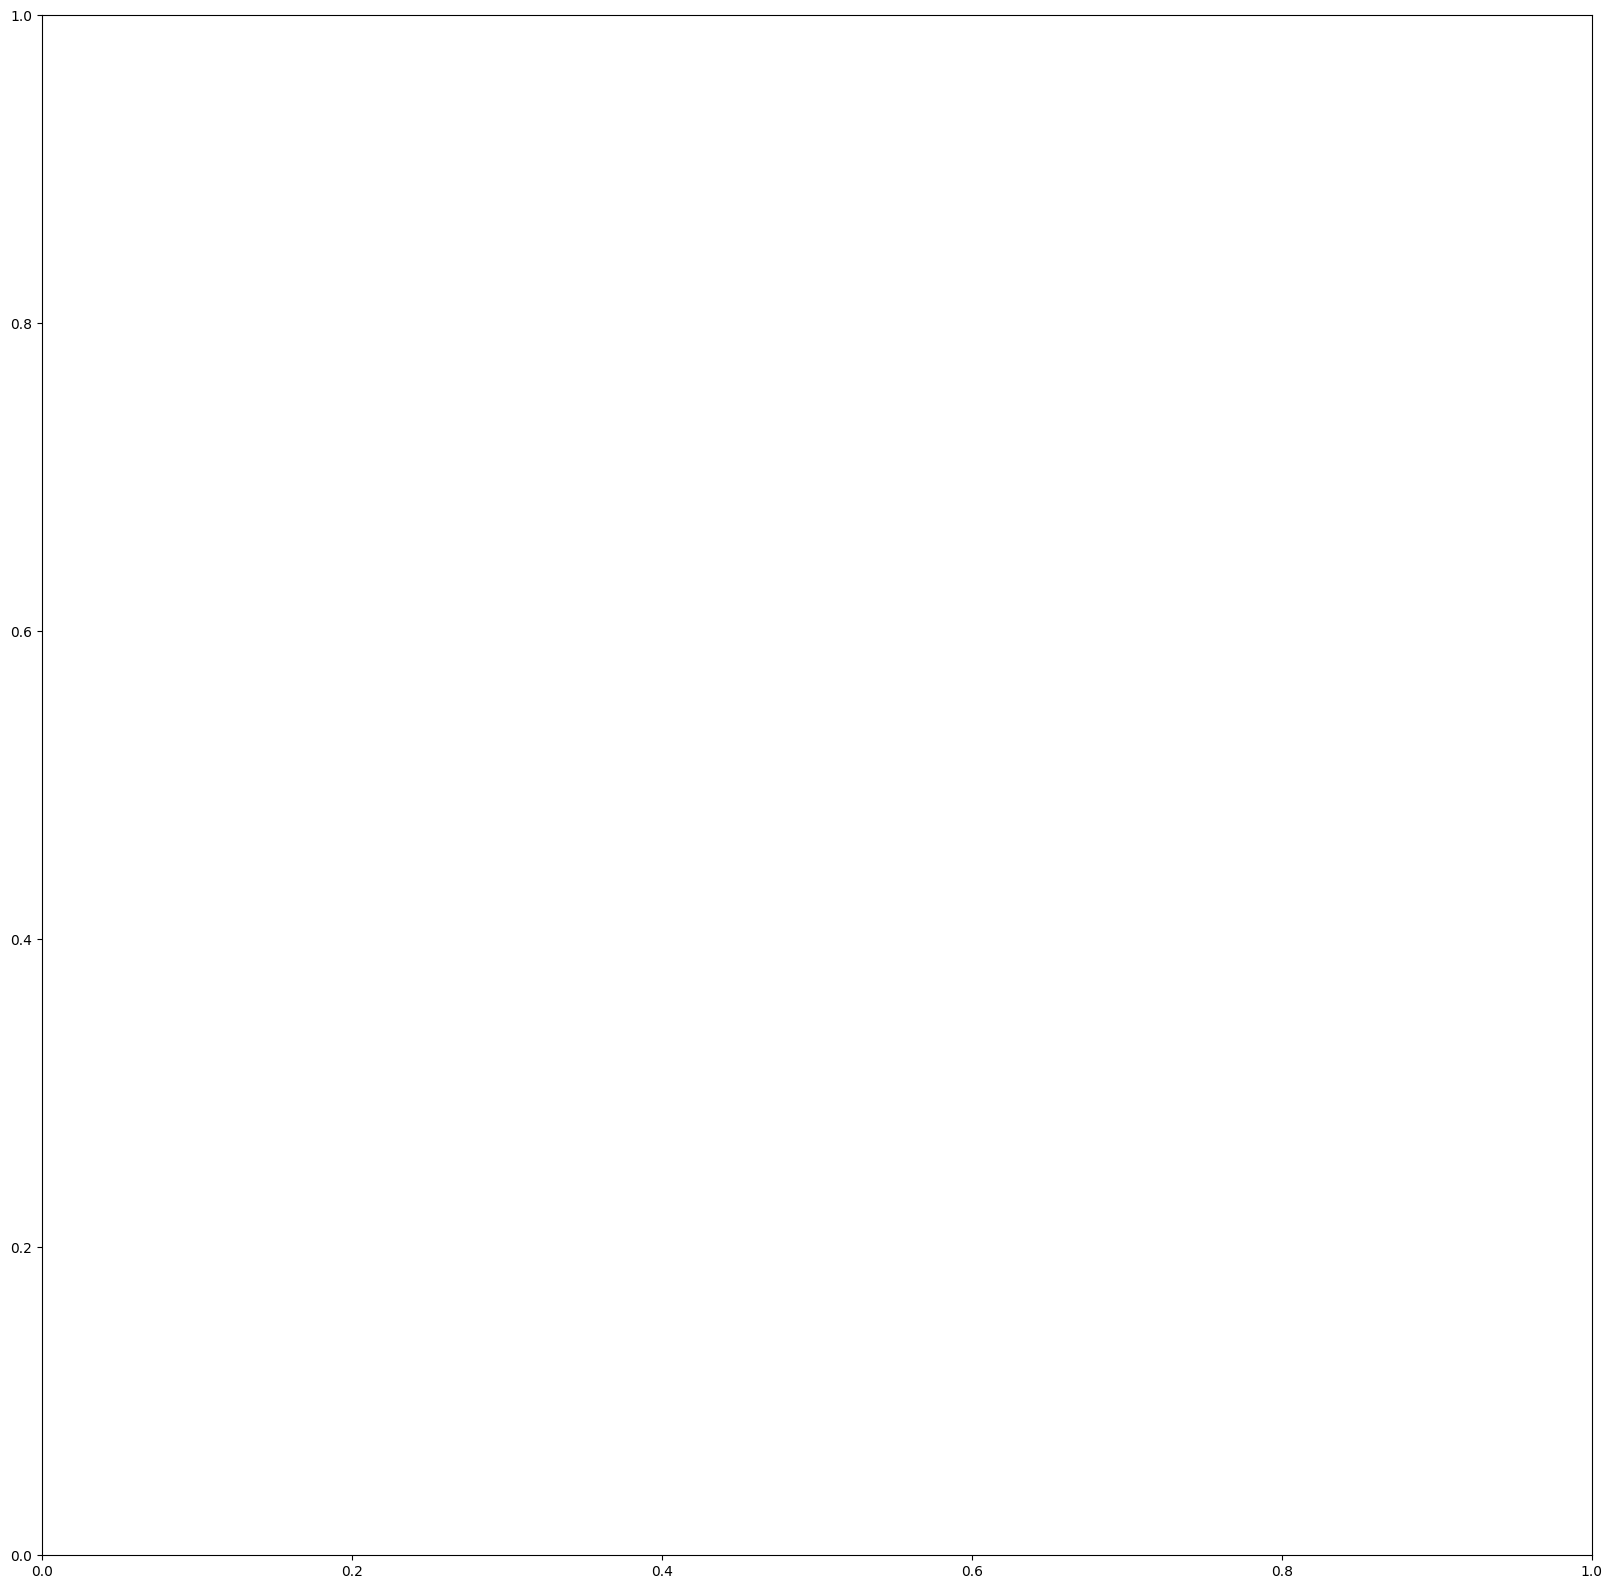

In [ ]:
kal_ckpt = [4424] #ckpt_step that holds the KF predictions for each experiment
kal_err = get_other_err(valA, C_dist, kal_ckpt[0], experiments[3], "Kalman", nx=nx)

num_tasks = [10000, 20000, 30000, 40000]

ckpt_steps = [20000, 40000, 59000, 79000]
tasks_quant = []

i = 0
for experiment in experiments:
    pred_ckpts = []
    medians = []
    print("\n\ni", i)
    mop_err, pred_ckpt = get_mop_ratios_ckpt(valA, C_dist, ckpt_steps[i], experiment, nx=nx)
    quantiles = compute_ratio(ind=250, err=mop_err, kalman_err=kal_err)
    if isinstance(quantiles, torch.Tensor):
        quantiles = quantiles.cpu().numpy()
    del mop_err
    tasks_quant.append(quantiles)

    torch.cuda.empty_cache()
    gc.collect()
        

    i+=1


tasks_quant = np.array(tasks_quant)
print("shape of tasks_quant", tasks_quant.shape)

step  0
err: 1.5159832085535253e-05
coeff: [14, -0.5, 1, 0]
step  100
err: 4.148511619817163e-07
coeff: [np.float64(13.999948362618674), -0.5, np.float64(0.9961605259976986), 0]
step  200
err: 4.1481557748973243e-07
coeff: [np.float64(13.99992949945155), -0.5, np.float64(0.9961606870044656), 0]
step  300
err: 4.1477999604981453e-07
coeff: [np.float64(13.999910637093459), -0.5, np.float64(0.996160848005108), 0]
step  400
err: 4.147444176622078e-07
coeff: [np.float64(13.999891775544357), -0.5, np.float64(0.996161008998845), 0]
step  500
err: 4.147088423261439e-07
coeff: [np.float64(13.999872914804214), -0.5, np.float64(0.9961611699856773), 0]
step  600
err: 4.1467327004185555e-07
coeff: [np.float64(13.999854054872992), -0.5, np.float64(0.9961613309656049), 0]
step  700
err: 4.1463770080857435e-07
coeff: [np.float64(13.99983519575066), -0.5, np.float64(0.9961614919386281), 0]
step  800
err: 4.14602134626533e-07
coeff: [np.float64(13.999816337437176), -0.5, np.float64(0.9961616529047476), 

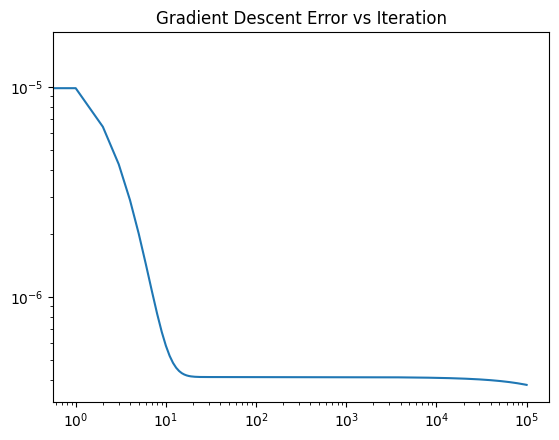

In [86]:
steps = int(1e5)
fincoeff, train_error = grad_descent_pow(num_tasks[0:2], tasks_quant[0:2,1], [14, -0.5, 1, 0], 1e-1, steps) #-3e-4

plt.plot(list(range(steps)), train_error)
plt.title("Gradient Descent Error vs Iteration")
plt.yscale("log")
plt.xscale("log")
plt.show()

/home/sultand/mop_modifications/streamlined_mop/outputs/train_conv/num_tasks_train_zoomedin_gaussA_val_gaussA_val_sys_1000_1731448587.9019387.png


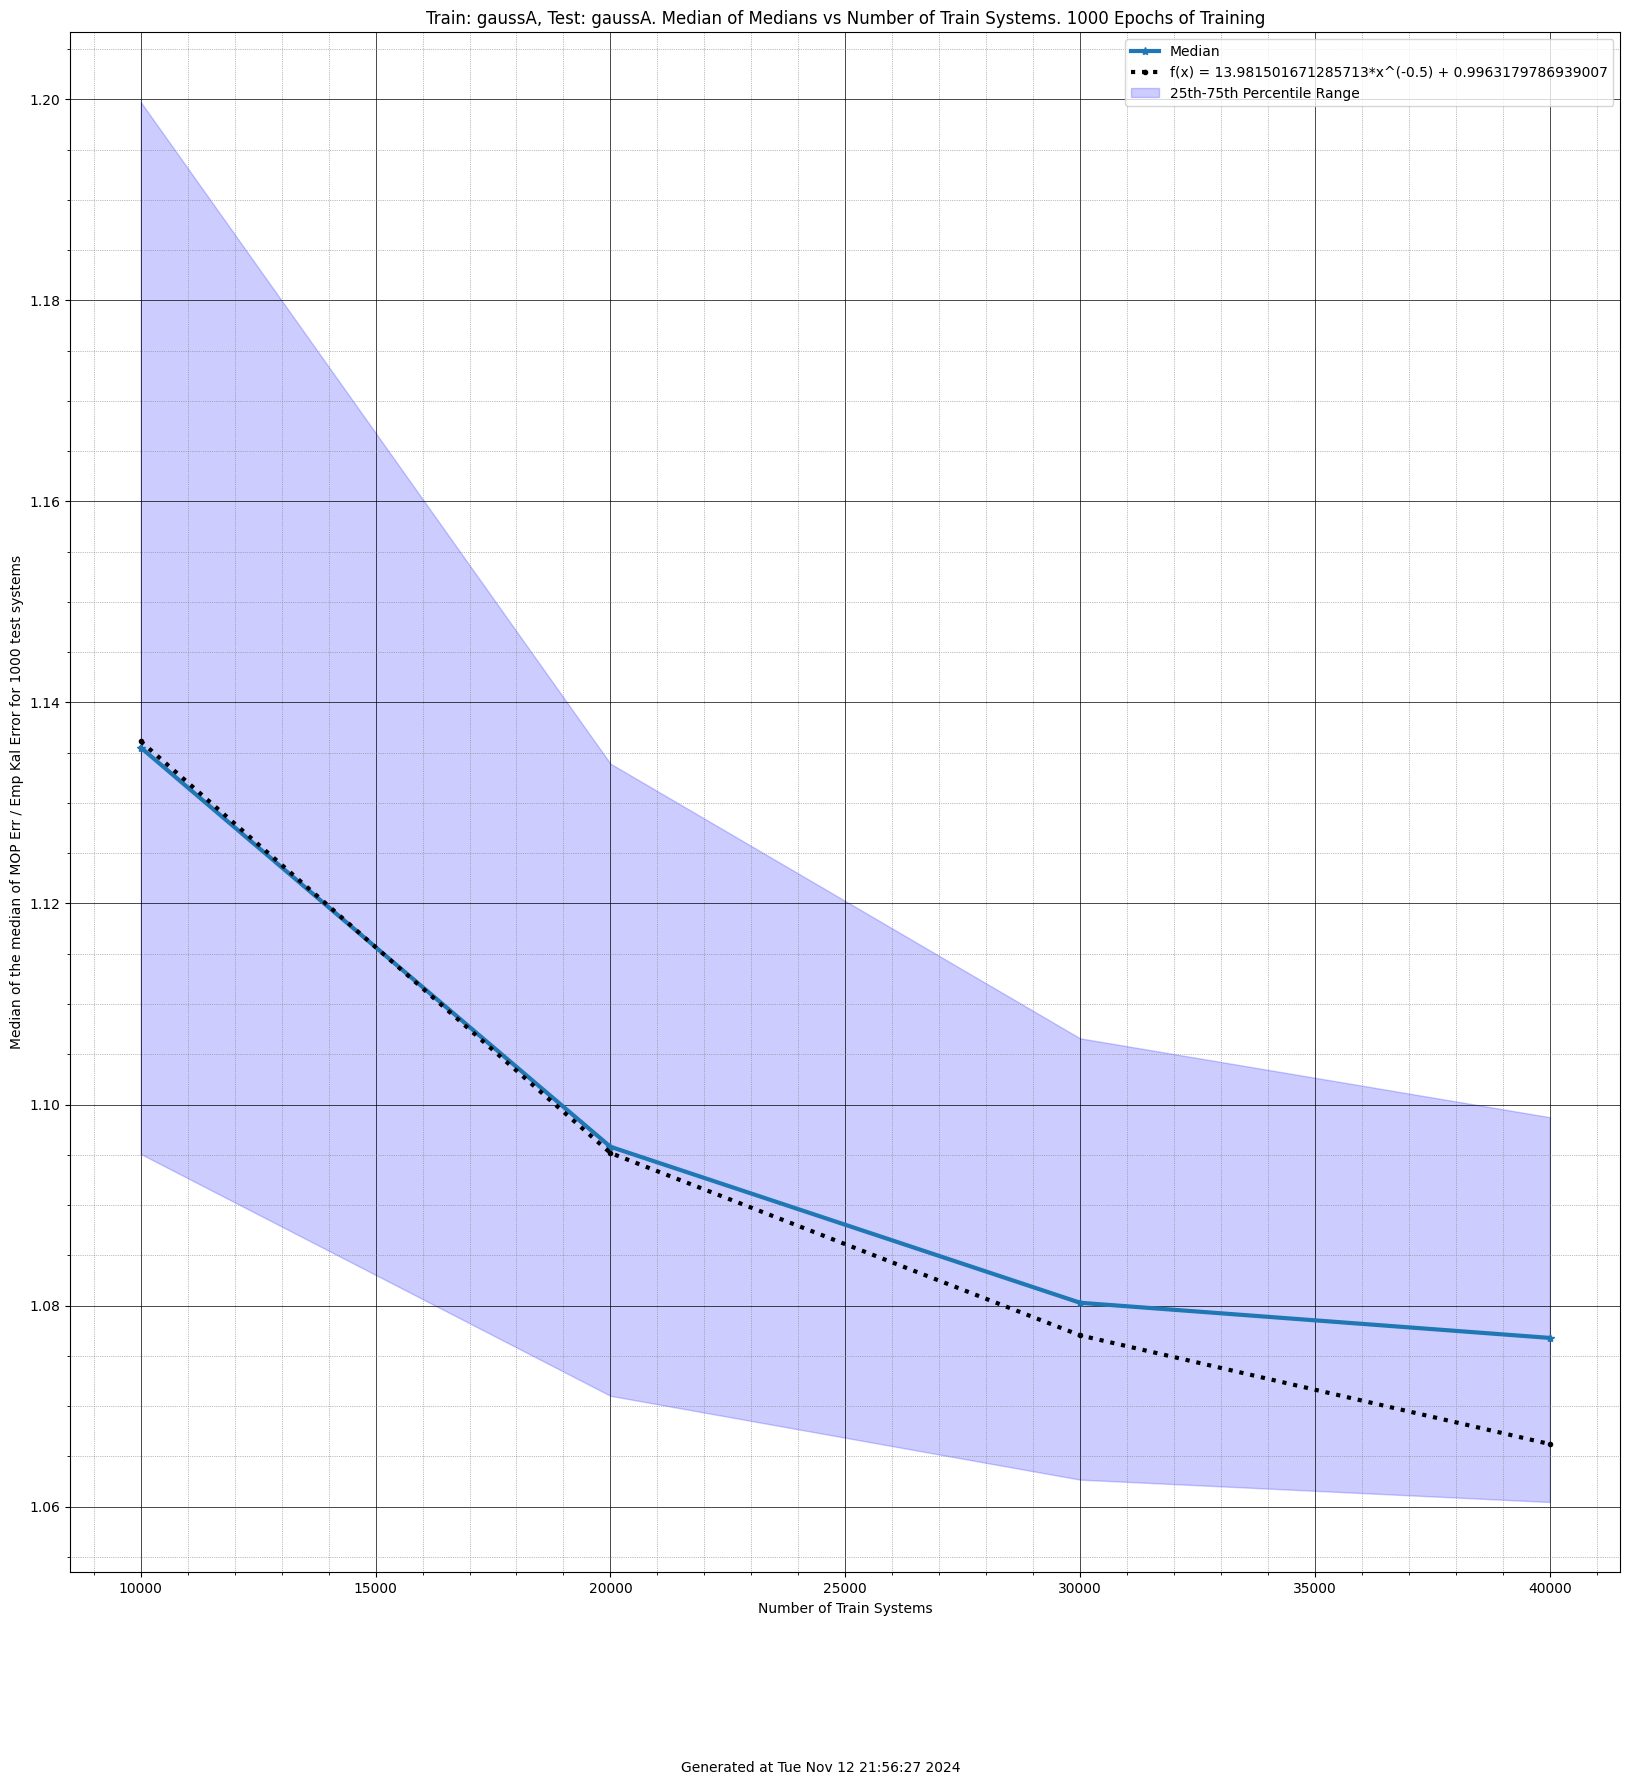

In [ ]:
#create a figure with subplots for each of the m indexes for the cdfs
fig, ax = plt.subplots(1, 1, figsize=(20, 20), sharex=True)
##plotting stuff
ax.plot(num_tasks, tasks_quant[:,1], marker="*", linewidth=3, label="Median")
ax.plot(num_tasks, power(num_tasks, fincoeff[0], fincoeff[1], fincoeff[2], fincoeff[3]), marker = ".", color="black", linewidth=3, linestyle = ":", label=f"f(x) = {fincoeff[0]}*x^({fincoeff[1]}) + {fincoeff[2]}")
plt.fill_between(num_tasks, tasks_quant[:,0], tasks_quant[:,2], color='blue', alpha=0.2, label='25th-75th Percentile Range')

ax.set_title(f"Train: {trainA}, Test: {valA}_state_dim_{nx}. Median of Medians vs Number of Train Systems. 1000 Epochs of Training")
ax.grid(True)
ax.set_ylabel("Median of the median of MOP Err / Emp Kal Error for 1000 test systems")
ax.set_xlabel("Number of Train Systems")
ax.minorticks_on()
ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
ax.legend()
# ax.set_ylim(1.0, 2.6)

fig.text(0.5, 0.01, f'Generated at {time.ctime()}', ha='center')

filename = f'num_tasks_train_zoomedin_{trainA}_val_{valA}_state_dim_{nx}_val_sys_{num_val_systems}_{time.time()}.png'

filepath = os.path.abspath(f"../outputs/train_conv/{filename}")
print(filepath)

os.makedirs(os.path.dirname(filepath), exist_ok=True)
#save the figures
fig.savefig(filepath)